# CIFAR-10 CNN with Data Augmentation

This notebook demonstrates training a CNN on CIFAR-10 with data augmentation techniques including random cropping and horizontal flipping.

## 1. Import Libraries and Setup

In [12]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt

print("Libraries imported successfully.")

Libraries imported successfully.


## 2. Define Data Augmentation Transformations

In [13]:
# Define augmented transformations for training data
train_transform = transforms.Compose(
    [
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

# Define standard transformations for test data (no augmentation)
test_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

print("Data augmentation transformations defined.")
print("- Training transforms: RandomCrop(32, padding=4), RandomHorizontalFlip")
print("- Test transforms: Standard normalization")

Data augmentation transformations defined.
- Training transforms: RandomCrop(32, padding=4), RandomHorizontalFlip
- Test transforms: Standard normalization


## 3. Load CIFAR-10 Dataset with Augmentation

In [14]:
# Load CIFAR-10 dataset with augmentation
trainset_augmented = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=train_transform
)
testset_augmented = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=test_transform
)

# Create subsets for faster training
train_subset_size = 10000
test_subset_size = 2000

train_indices = torch.randperm(len(trainset_augmented))[:train_subset_size]
test_indices = torch.randperm(len(testset_augmented))[:test_subset_size]

train_subset_augmented = Subset(trainset_augmented, train_indices)
test_subset_augmented = Subset(testset_augmented, test_indices)

# Create DataLoaders
batch_size = 64
trainloader_aug = DataLoader(train_subset_augmented, batch_size=batch_size, shuffle=True)
testloader_aug = DataLoader(test_subset_augmented, batch_size=batch_size, shuffle=False)

print(f"CIFAR-10 training dataset loaded with {len(train_subset_augmented)} samples (with augmentation)")
print(f"CIFAR-10 test dataset loaded with {len(test_subset_augmented)} samples")
print(f"DataLoaders created with batch size {batch_size}")

CIFAR-10 training dataset loaded with 10000 samples (with augmentation)
CIFAR-10 test dataset loaded with 2000 samples
DataLoaders created with batch size 64


## 4. Define CNN Model

In [15]:
# Define a Convolutional Neural Network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

print("CNN model architecture defined.")

CNN model architecture defined.


## 5. Define Training and Validation Functions

In [16]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / total_samples
    epoch_accuracy = correct_predictions / total_samples
    return epoch_loss, epoch_accuracy

def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / total_samples
    epoch_accuracy = correct_predictions / total_samples
    return epoch_loss, epoch_accuracy

print("Training and validation functions defined.")

Training and validation functions defined.


## 6. Train Model with Data Augmentation

In [17]:
# Setup device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Training parameters
num_epochs = 10
learning_rates = [0.01, 0.001]

# Dictionary to store results for each learning rate
augmented_results = {}

print(f"\n--- Training with Data Augmentation (Multiple Learning Rates) ---")
print(f"Epochs: {num_epochs}, Batch Size: {batch_size}\n")

for lr in learning_rates:
    print(f"\n{'='*80}")
    print(f"Training with Learning Rate: {lr}")
    print(f"{'='*80}\n")
    
    # Initialize model and optimizer for this learning rate
    model_aug = Net().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model_aug.parameters(), lr=lr, momentum=0.9)
    
    # Lists to store metrics for this learning rate
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(model_aug, trainloader_aug, criterion, optimizer, device)
        val_loss, val_acc = validate_epoch(model_aug, testloader_aug, criterion, device)
        
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    # Store results for this learning rate
    augmented_results[lr] = {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies,
        'model': model_aug
    }
    
    print(f"\nTraining completed for LR={lr}!")
    print(f"Final Validation Accuracy: {val_accuracies[-1]:.4f}")
    print(f"Final Validation Loss: {val_losses[-1]:.4f}\n")

Using device: cpu

--- Training with Data Augmentation (Multiple Learning Rates) ---
Epochs: 10, Batch Size: 64


Training with Learning Rate: 0.01

Epoch 1/10 | Train Loss: 2.2817, Train Acc: 0.1429 | Val Loss: 2.1504, Val Acc: 0.2175
Epoch 2/10 | Train Loss: 2.0466, Train Acc: 0.2393 | Val Loss: 1.9655, Val Acc: 0.2710
Epoch 3/10 | Train Loss: 1.8509, Train Acc: 0.3073 | Val Loss: 1.7122, Val Acc: 0.3590
Epoch 4/10 | Train Loss: 1.7522, Train Acc: 0.3440 | Val Loss: 1.6348, Val Acc: 0.4070
Epoch 5/10 | Train Loss: 1.6829, Train Acc: 0.3734 | Val Loss: 1.7038, Val Acc: 0.3850
Epoch 6/10 | Train Loss: 1.6442, Train Acc: 0.3913 | Val Loss: 1.5271, Val Acc: 0.4375
Epoch 7/10 | Train Loss: 1.6059, Train Acc: 0.4058 | Val Loss: 1.4714, Val Acc: 0.4695
Epoch 8/10 | Train Loss: 1.5448, Train Acc: 0.4319 | Val Loss: 1.4907, Val Acc: 0.4585
Epoch 9/10 | Train Loss: 1.5207, Train Acc: 0.4416 | Val Loss: 1.4326, Val Acc: 0.4740
Epoch 10/10 | Train Loss: 1.4822, Train Acc: 0.4581 | Val Loss: 1.43

## 7. Visualize Training Results

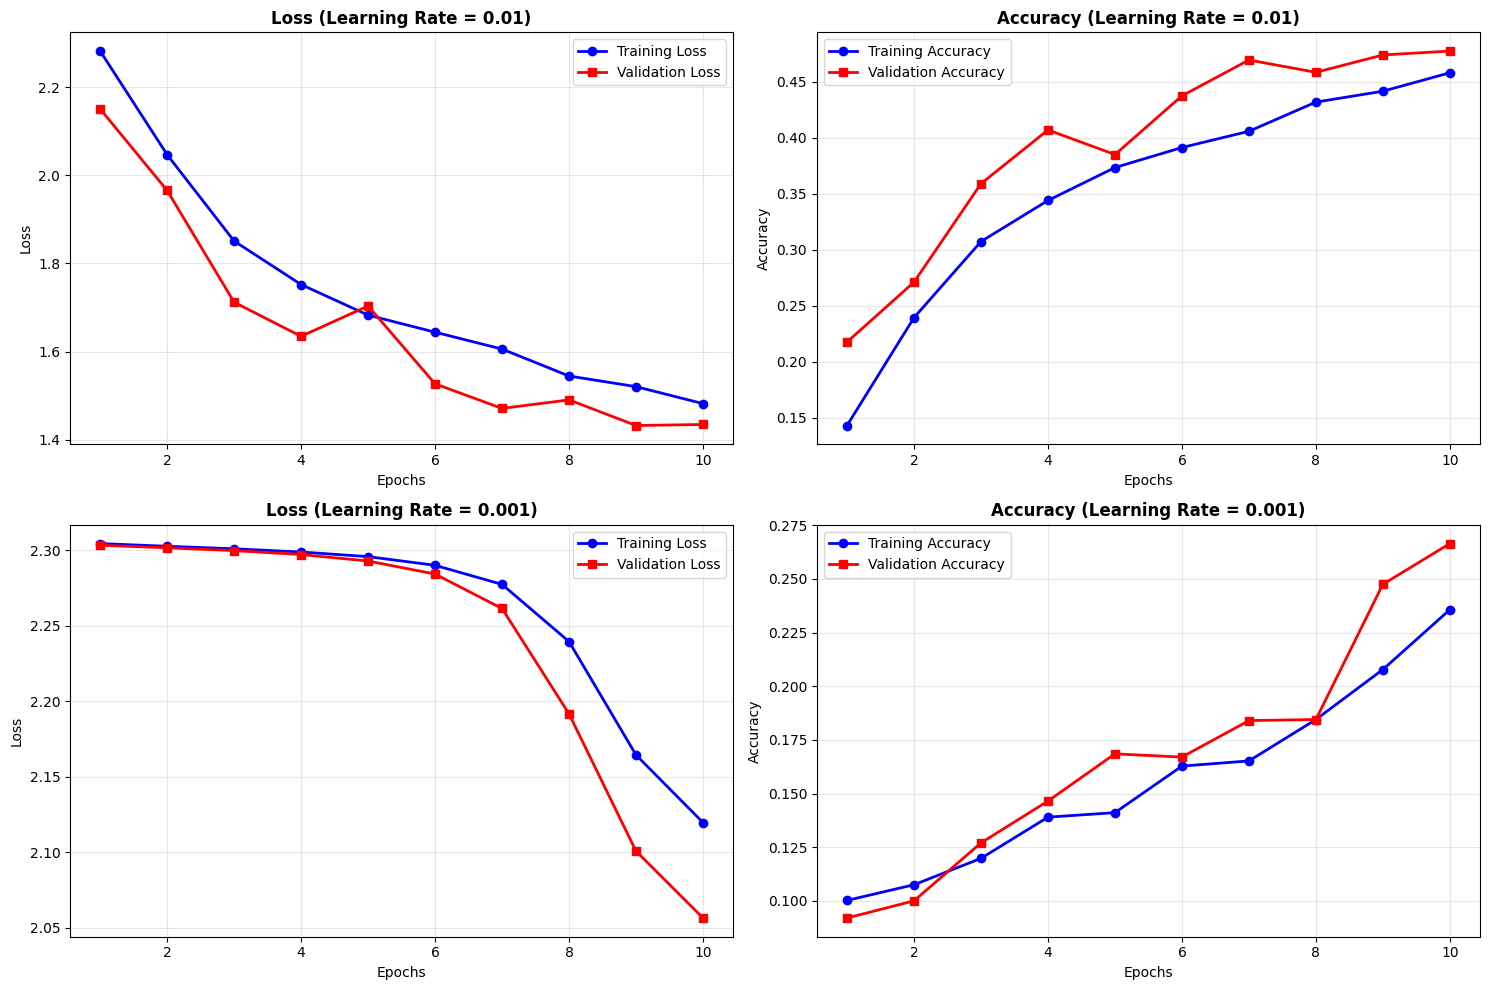

Training curves plotted for both learning rates.


In [18]:
epochs_range = range(1, num_epochs + 1)

# Create figure with subplots for each learning rate
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

colors = ['#FF6B6B', '#4ECDC4']

for idx, (lr, results) in enumerate(augmented_results.items()):
    train_losses = results['train_losses']
    train_accuracies = results['train_accuracies']
    val_losses = results['val_losses']
    val_accuracies = results['val_accuracies']
    
    # Plot Loss for this learning rate
    axes[idx, 0].plot(epochs_range, train_losses, 'b-', label='Training Loss', marker='o', linewidth=2)
    axes[idx, 0].plot(epochs_range, val_losses, 'r-', label='Validation Loss', marker='s', linewidth=2)
    axes[idx, 0].set_title(f'Loss (Learning Rate = {lr})', fontsize=12, fontweight='bold')
    axes[idx, 0].set_xlabel('Epochs')
    axes[idx, 0].set_ylabel('Loss')
    axes[idx, 0].legend()
    axes[idx, 0].grid(True, alpha=0.3)
    
    # Plot Accuracy for this learning rate
    axes[idx, 1].plot(epochs_range, train_accuracies, 'b-', label='Training Accuracy', marker='o', linewidth=2)
    axes[idx, 1].plot(epochs_range, val_accuracies, 'r-', label='Validation Accuracy', marker='s', linewidth=2)
    axes[idx, 1].set_title(f'Accuracy (Learning Rate = {lr})', fontsize=12, fontweight='bold')
    axes[idx, 1].set_xlabel('Epochs')
    axes[idx, 1].set_ylabel('Accuracy')
    axes[idx, 1].legend()
    axes[idx, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Training curves plotted for both learning rates.")

## 8. Results Summary

In [19]:
# Create summary table for all learning rates
summary_data = []

for lr, results in augmented_results.items():
    train_accuracies = results['train_accuracies']
    train_losses = results['train_losses']
    val_accuracies = results['val_accuracies']
    val_losses = results['val_losses']
    
    summary_data.append({
        'Learning Rate': lr,
        'Best Training Accuracy': f"{max(train_accuracies):.4f}",
        'Final Validation Accuracy': f"{val_accuracies[-1]:.4f}",
        'Best Validation Accuracy': f"{max(val_accuracies):.4f}",
        'Final Training Loss': f"{train_losses[-1]:.4f}",
        'Final Validation Loss': f"{val_losses[-1]:.4f}"
    })

summary_df = pd.DataFrame(summary_data)
print("\n=== Data Augmentation Model Results (Learning Rate Comparison) ===")
display(summary_df)

print(f"\nTraining Configuration:")
print(f"  - Data Augmentation: Yes (RandomCrop + RandomHorizontalFlip)")
print(f"  - Number of Epochs: {num_epochs}")
print(f"  - Learning Rates: {learning_rates}")
print(f"  - Batch Size: {batch_size}")
print(f"  - Training Samples: {len(train_subset_augmented)}")
print(f"  - Validation Samples: {len(test_subset_augmented)}")

# Find best performing model
best_lr = max(augmented_results.items(), 
              key=lambda x: max(x[1]['val_accuracies']))
print(f"\n✓ Best performing Learning Rate: {best_lr[0]} with Validation Accuracy: {max(best_lr[1]['val_accuracies']):.4f}")


=== Data Augmentation Model Results (Learning Rate Comparison) ===


,Learning Rate,Best Training Accuracy,Final Validation Accuracy,Best Validation Accuracy,Final Training Loss,Final Validation Loss
0,0.010,0.4581,0.4775,0.4775,1.4822,1.4349
1,0.001,0.2357,0.2665,0.2665,2.1197,2.0564



Training Configuration:
  - Data Augmentation: Yes (RandomCrop + RandomHorizontalFlip)
  - Number of Epochs: 10
  - Learning Rates: [0.01, 0.001]
  - Batch Size: 64
  - Training Samples: 10000
  - Validation Samples: 2000

✓ Best performing Learning Rate: 0.01 with Validation Accuracy: 0.4775
